In [1]:
#Model development for Trawling4PACE
#Authors: HS, VA, FB, PP
#History: 1/29/26
#Goals: Run Random forest and boosted regression tree models for predicting silver hake abundance

In [168]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [5]:
os.chdir('/home/jovyan/2026-proj-Trawling4PACE/data')

In [134]:
df= pd.read_csv('/home/jovyan/2026-proj-Trawling4PACE/contributor_folders/leandro/correlation_data.csv')

In [140]:
pd.to_datetime(df.BEGIN_GMT_TOWDATE).dt.month

0        3
1        3
2        3
3        3
4        3
        ..
14491    9
14492    9
14493    9
14494    9
14495    9
Name: BEGIN_GMT_TOWDATE, Length: 14496, dtype: int32

In [141]:
#Data cleaning 
#all values in glorys_thetao_bottom are NAN so we need to clean them out 
df['month']=pd.to_datetime(df.BEGIN_GMT_TOWDATE).dt.month
df['day']=pd.to_datetime(df.BEGIN_GMT_TOWDATE).dt.day
df['year']=pd.to_datetime(df.BEGIN_GMT_TOWDATE).dt.year
df['doy']= [datetime.date(df.year[x],df.month[x],df.day[x]).timetuple().tm_yday for x in df.index]

df = df.drop(['glorys_thetao_bottom','BEGIN_GMT_TOWDATE'],axis=1).dropna()

#PLACEHOLDER for standardizing variables / outlier removal 
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [157]:
#SPLIT DATA INTO TRAINING/TESTING 
y = df['EXPCATCHNUM_log']
X = df[['DECDEG_ENDLAT', 'DECDEG_ENDLON', 'curl_stress_curl', 'fsle_fsle_max','glorys_mlotst_surface',
       'glorys_thetao_surface','BOTTEMP', 'BOTSALIN', 'SURFSALIN', 'SURFTEMP','doy','year']]

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
X.corr()

,DECDEG_ENDLAT,DECDEG_ENDLON,BOTTEMP,BOTSALIN,SURFSALIN,SURFTEMP,curl_stress_curl,fsle_fsle_max,glorys_bottomT_surface,glorys_mlotst_surface,glorys_so_surface,glorys_thetao_surface
DECDEG_ENDLAT,1.000000,0.851298,-0.638629,-0.192554,-0.504464,-0.575236,-0.216248,0.072437,-0.570713,-0.372298,-0.544662,-0.590408
DECDEG_ENDLON,0.851298,1.000000,-0.510682,-0.048413,-0.196453,-0.461527,-0.269485,-0.036873,-0.482157,-0.270102,-0.320078,-0.489425
BOTTEMP,-0.638629,-0.510682,1.000000,0.758644,0.583846,0.619598,0.032839,-0.271062,0.826386,0.365344,0.643520,0.640224
BOTSALIN,-0.192554,-0.048413,0.758644,1.000000,0.535647,0.336763,-0.171123,-0.233031,0.619304,0.174734,0.536180,0.332101
SURFSALIN,-0.504464,-0.196453,0.583846,0.535647,1.000000,0.616037,-0.129269,-0.132110,0.493932,0.454563,0.769844,0.547024
SURFTEMP,-0.575236,-0.461527,0.619598,0.336763,0.616037,1.000000,0.084285,-0.322381,0.571432,0.382146,0.638127,0.919518
curl_stress_curl,-0.216248,-0.269485,0.032839,-0.171123,-0.129269,0.084285,1.000000,0.044909,0.010421,-0.075065,0.010284,0.098038
fsle_fsle_max,0.072437,-0.036873,-0.271062,-0.233031,-0.132110,-0.322381,0.044909,1.000000,-0.250943,-0.135875,-0.216416,-0.284372
glorys_bottomT_surface,-0.570713,-0.482157,0.826386,0.619304,0.493932,0.571432,0.010421,-0.250943,1.000000,0.286996,0.527060,0.609772
glorys_mlotst_surface,-0.372298,-0.270102,0.365344,0.174734,0.454563,0.382146,-0.075065,-0.135875,0.286996,1.000000,0.499067,0.410545


In [158]:
#hyperparameterization
param_grid={'n_estimators':[100,200,300],
            'max_features':['sqrt','log2',0.8],
           'max_depth':[10,20,30,None]}
from sklearn.model_selection import GridSearchCV
model=RandomForestRegressor()
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print(grid_search.best_params_)

# Print the best score achieved (neg_mean_squared_error, so lower is better for actual MSE)
print(grid_search.best_score_)

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}
-0.7841664221249275


In [159]:
#n_estimators == # of decision trees 
#oob_score == out of bag estimate of models general error
#random_state is for reproducibility

#optimize the number of trees?
#hyperparameterization
regressor = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'], max_features= grid_search.best_params_['max_features'],max_depth = grid_search.best_params_['max_depth'],random_state=0, oob_score=True)

regressor.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'log2'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [160]:
from sklearn.metrics import mean_squared_error, r2_score

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: -0.04486126167637883
Mean Squared Error: 0.7387073189426082
R-squared: -0.01334841496617023


In [161]:
importances = regressor.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)
print(feature_imp_df)

                   Feature  Gini Importance
3                 BOTSALIN         0.112916
2                  BOTTEMP         0.101316
1            DECDEG_ENDLON         0.101067
0            DECDEG_ENDLAT         0.101066
7            fsle_fsle_max         0.095268
10       glorys_so_surface         0.093126
4                SURFSALIN         0.084812
8   glorys_bottomT_surface         0.079351
11   glorys_thetao_surface         0.070352
5                 SURFTEMP         0.066310
6         curl_stress_curl         0.048855
9    glorys_mlotst_surface         0.045562


/tmp/ipykernel_249/2496803616.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


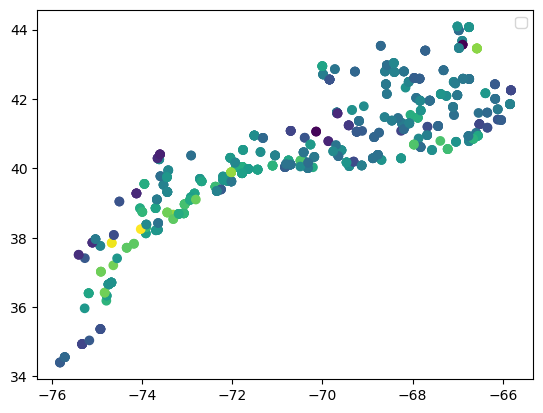

In [133]:
plt.scatter(X_test.DECDEG_ENDLON, X_test.DECDEG_ENDLAT, c=predictions) 
plt.legend()

In [164]:
#BOOSTED REGRESSION TREE 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
import shap

In [ ]:
param_grid={'n_estimators':[100,200,300],
            'learning_rate':[0.1,0.05,0.01],
           'max_depth':[5,10,20,30,None],
           'reg_alpha':[0.005, .05, .1],
           'reg_lambda':[0.05, 0.1, 1, 2]}
from sklearn.model_selection import GridSearchCV
model=xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print(grid_search.best_params_)

# Print the best score achieved (neg_mean_squared_error, so lower is better for actual MSE)
print(grid_search.best_score_)

In [181]:
xgb_reg = xgb.XGBRegressor(
    # --- Boosting Parameters (How the model learns) ---
    n_estimators=10,         # Analogous to the "richness" of the model. Number of trees to build.
                               # We set this high and use early stopping to find the optimal number.
    learning_rate=0.01,        # Analogous to a shrinkage parameter. Lower values make the model more robust.

    # --- Tree Complexity Parameters ---
    max_depth=5,               # Analogous to `k` in s(x, k=...). Controls max interaction depth.
    min_child_weight=1,        # A form of regularization. Prevents learning highly specific patterns.
    gamma=0.1,                 # Analogous to `sp`. A value > 0 penalizes splits, making the model more conservative.
    subsample=0.8,             # Use 80% of data for building each tree. Adds randomness to fight overfitting.
    colsample_bytree=0.8,      # Use 80% of features for building each tree. Also for overfitting.

    # --- Regularization Parameters ---
    reg_alpha=0.005,           # L1 regularization on leaf weights.
    reg_lambda=1,              # L2 regularization on leaf weights.

    # --- Technical Parameters ---
    objective='reg:squarederror', # The loss function to optimize.
    n_jobs=-1,                 # Use all available CPU cores.
    random_state=42,           # For reproducibility.
    eval_metric='rmse'         # Metric to monitor during training.
)

print("Model initialized with parameters:")
print(xgb_reg.get_params())

xgb_reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False) # Set verbose=True to see the training progress

print(f"Model training complete.")

Model initialized with parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 10, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.005, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Model training complete.


In [182]:
results = xgb_reg.evals_result()
best_iteration = np.argmin(results['validation_0']['rmse'])
best_score = results['validation_0']['rmse'][best_iteration]

print(f"Best iteration found: {best_iteration}")
print(f"Best validation RMSE: {best_score:.4f}")

Best iteration found: 9
Best validation RMSE: 0.8522


In [183]:
print("\n--- Step 4: Making Predictions ---")
predictions_brt = xgb_reg.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions_brt))
print(f"Final RMSE on validation data: {rmse:.4f}")


--- Step 4: Making Predictions ---
Final RMSE on validation data: 0.8522


Plotting feature importance...


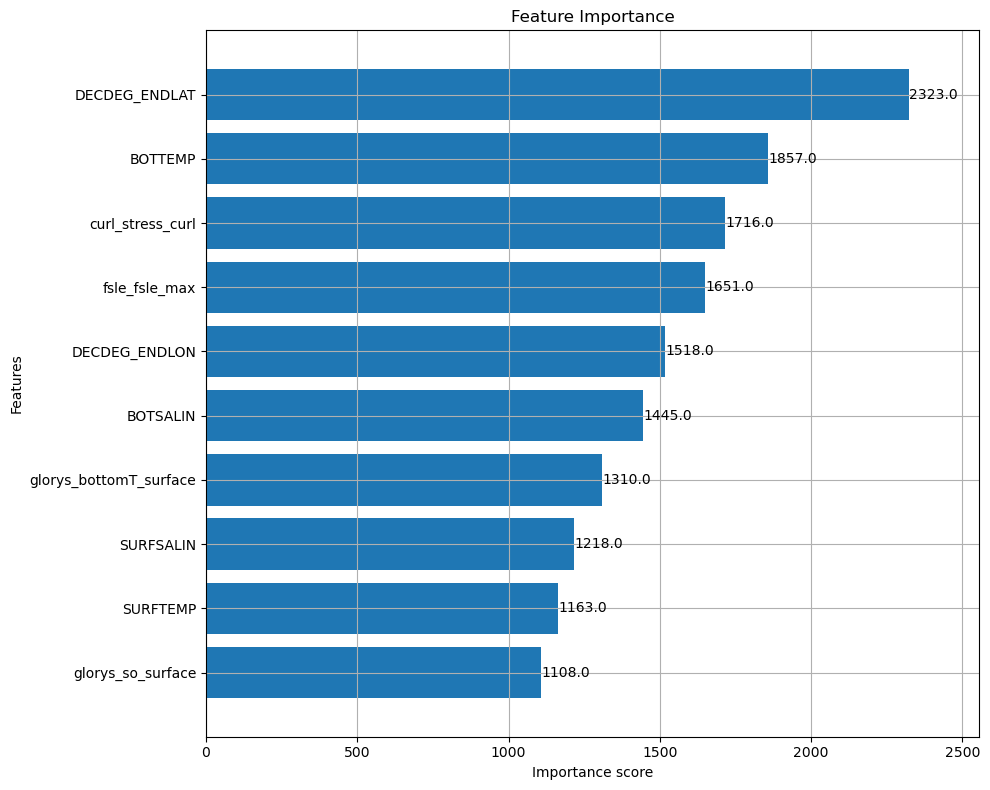

In [179]:
print("Plotting feature importance...")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax=ax, max_num_features=10, height=0.8, title="Feature Importance")
plt.tight_layout()
plt.show()

In [184]:
mse = mean_squared_error(y_test, predictions_brt)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions_brt)
print(f'R-squared: {r2}')

Mean Squared Error: 0.726192273427215
R-squared: 0.0038195502225413236
